In [1]:
import nengo
import nengo_spa as spa
import nengolib
import nengo_extras
import pytry
import numpy as np
import pylab
import pandas as pd
import seaborn as sns
import itertools
import scipy
import string
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA
from nengo_extras.plot_spikes import (
    cluster, merge, plot_spikes, preprocess_spikes, sample_by_variance)
from nengo.utils.ensemble import response_curves, tuning_curves

import os
import sys

%pylab inline
import pylab
import cycler
import matplotlib.collections as mcol

%run ../dashedlines.py
%run ../UTC.py

Populating the interactive namespace from numpy and matplotlib


/Users/Joost/opt/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False



## Selective attention

In [3]:
%%capture

#gain_list = np.array([0, 0.0625, 0.125, 0.25, 0.5, 1])
gain_list = np.arange(0., 2.25, 0.25)

wm_readout = []
a_readout = []
b_readout = []

colors = plt.cm.Reds(np.linspace(0.3, 1, len(gain_list)))

for i in range(len(gain_list)):   
    with spa.Network(seed=0) as network:
        vector_a = np.array([np.cos(np.pi/10), np.sin(np.pi/10)])
        vector_b = np.array([np.cos(np.pi/10 + np.pi/2), np.sin(np.pi/10 + np.pi/2)]) * gain_list[i]

        input_a = nengo.Node(output=vector_a)
        input_b = nengo.Node(output=vector_b)
        
        a_ens = nengo.Ensemble(n_neurons=100, dimensions=2, radius=1)
        b_ens = nengo.Ensemble(n_neurons=100, dimensions=2, radius=1)

        wm_ens = nengo.Ensemble(n_neurons=100, neuron_type=nengo.LIF(),
                                  dimensions=2, radius=1)
        
        r = nengo.Node(size_in=2)

        aa = nengo.Connection(input_a, a_ens)
        bb = nengo.Connection(input_b, b_ens)
        awm = nengo.Connection(a_ens, wm_ens)
        bwm = nengo.Connection(b_ens, wm_ens)
        readout = nengo.Connection(wm_ens, r)

        a_probe = nengo.Probe(a_ens)
        b_probe = nengo.Probe(b_ens)
        wm_probe = nengo.Probe(wm_ens)
        wm_encoders = nengo.Probe(wm_ens, 'scaled_encoders')
        spike_probe = nengo.Probe(wm_ens.neurons)
        
    with nengo.Simulator(network) as sim:
        sim.run(0.2)
        
    a_readout.append(nengo.Alpha(0.02).filt(sim.data[a_probe])[-1,:])
    b_readout.append(nengo.Alpha(0.02).filt(sim.data[b_probe])[-1,:])
    wm_readout.append(nengo.Alpha(0.02).filt(sim.data[wm_probe])[-1,:])
    
    #ax.plot(nengo.Alpha(0.02).filt(sim.data[wm_probe][:,0]),
    #        color=colors[i])

In [4]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

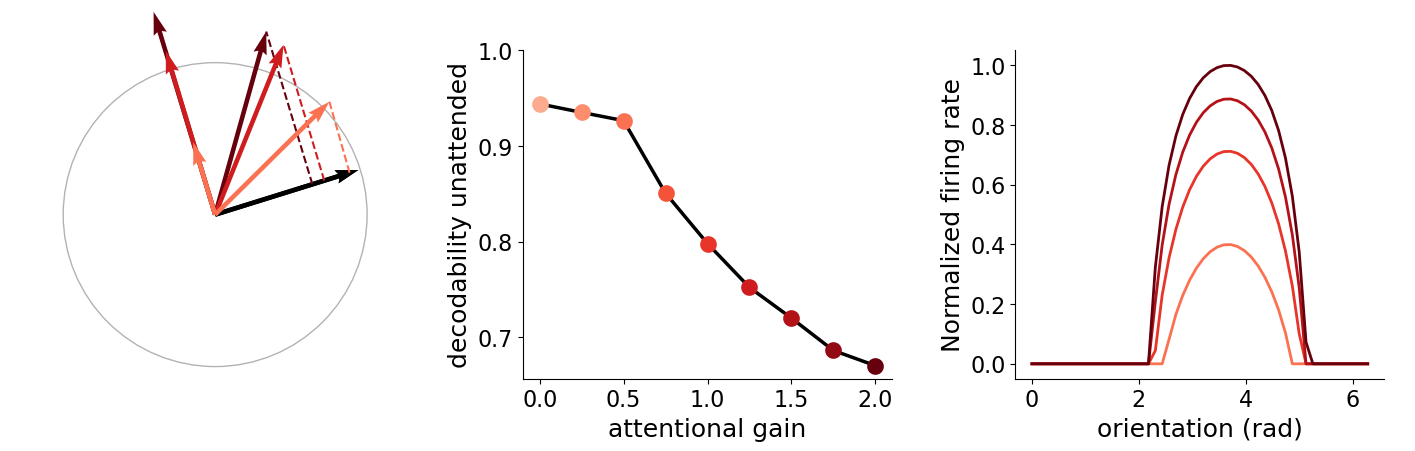

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
colors = plt.cm.Reds(np.linspace(0.3, 1, len(gain_list)))

ax1.axis('square')
ax1.axis('off')
ax2.axis('square')
ax2.axis('off')
ax3.axis('square')
ax3.axis('off')

origin = np.array([[0, 0],[0, 0]]) # origin point

# Spiking (normalization)
V_neural = a_readout[0]

lim = 1.35
ax1.set_xlim([-1.01, 1.01])
ax1.set_ylim([-1.01, lim])

#ax1.text(0, 1.4, 'Attentional gain', ha='center', size=20)

ax1.quiver(*origin, V_neural[0], V_neural[1], scale=1, units='xy',
          color='black', width=0.03)

circle = plt.Circle((0,0), radius=1, fill=False, alpha=0.3, zorder=1)
ax1.add_patch(circle)

for i in range(2, len(gain_list), 3):   
    # Spiking (normalization)
    V_neural = np.array([a_readout[i], wm_readout[i]])
    angle = angle_between(V_neural[0,:], V_neural[1,:])
    norm = np.linalg.norm(V_neural[1])
    ax1.plot([np.cos(angle) * norm * V_neural[0,0], V_neural[1,0]], 
         [np.cos(angle) * norm * V_neural[0,1], V_neural[1,1]], 
         color=colors[i], alpha=1., ls='--', zorder=50-i)
    
    
    V_neural = np.array([b_readout[i], wm_readout[i]])

    ax1.set_xlim([-lim, lim])
    ax1.set_ylim([-lim, lim])

    ax1.quiver(*origin, V_neural[:,0], V_neural[:,1], 
              color=colors[i], scale=1, units='xy', width=0.03,
              zorder=50-i)

    
axins2 = ax2.inset_axes([0.05, 0.1, 0.9, 0.8])

axins2.spines['right'].set_visible(False)
axins2.spines['top'].set_visible(False)

dots = []

for i in range(0, len(gain_list)):   
    axins2.scatter(gain_list[i], spa.dot(a_readout[i], wm_readout[i]),
         color=colors[i], alpha=1., lw=6, label='{}'.format(gain_list[i]))
    dots.append(spa.dot(a_readout[i], wm_readout[i]))
    
axins2.plot(gain_list, dots, color='black', lw=2.5, zorder=0)

axins2.set_xlabel('attentional gain', size=18)
axins2.set_ylabel('decodability unattended', size=18)
axins2.set_yticks(ticks=[0.7, 0.8, 0.9, 1])
axins2.set_xticks(ticks=[0, 0.5, 1, 1.5, 2])

axins3 = ax3.inset_axes([0.05, 0.1, 0.9, 0.8])

axins3.spines['right'].set_visible(False)
axins3.spines['top'].set_visible(False)

gains = gain_list
k = 7
for i in range(2, len(gain_list), 2):   
    inputs = np.zeros((50, 2))
    inputs[:, 0] = np.cos(np.linspace(0, 2*np.pi, 50)) * np.max(gain_list)
    inputs[:, 1] = np.sin(np.linspace(0, 2*np.pi, 50)) * np.max(gain_list)
    eval_points, baseline_activity = tuning_curves(wm_ens, sim, inputs=inputs)
    baseline_max = np.max(baseline_activity[:,k])
    baseline_min = np.min(baseline_activity[:,k])
    baseline_mean = np.mean(baseline_activity[:,k])
    baseline_std = np.std(baseline_activity[:,k])
    
    inputs = np.zeros((50, 2))
    inputs[:, 0] = np.cos(np.linspace(0, 2*np.pi, 50)) * gain_list[i]
    inputs[:, 1] = np.sin(np.linspace(0, 2*np.pi, 50)) * gain_list[i]
    eval_points, activities = tuning_curves(wm_ens, sim, inputs=inputs)

    axins3.plot(np.linspace(0, 2*pi, 50), 
            (activities[:,k]-baseline_min)/(baseline_max - baseline_min),
            color=colors[i], label=gain_list[i], lw=2)
    

axins3.set_xlabel('orientation (rad)', size=18)
axins3.set_ylabel('Normalized firing rate', size=18)

axins2.tick_params(axis='both', which='major', labelsize=16)
axins3.tick_params(axis='both', which='major', labelsize=16)


In [6]:
fig.savefig('attention_normalization.png', dpi=400, bbox_inches='tight')
fig.savefig('attention_normalization.tiff', dpi=400, bbox_inches='tight')

## Divided Attention

In [7]:
# Set parameters
D = 64
dim = 6


def stimulus_function(t):
    if t > 0 and t < 0.25:
        return 'A'
    elif t > 0.25 and t < 0.5:
        return 'B'
    elif t > 0.5 and t < 0.75:
        return 'C'
    elif t > 0.75 and t < 1.:
        return 'D'
    else:
        return 0
    
gi_list = np.arange(0, 2.25, 0.25)

In [8]:
%%capture

for gi in gi_list:
    UTC().run(dimensions=dim,
                     D=D,
                     full_output=True,
                     direct_mode=False,
                     gain_i=gi,
                     task_type = 'prospective_sensory',
                     stimulus_function=stimulus_function,
                     data_dir='divided_attention',
                     trial_duration=1.5)

In [9]:
divided_attention_data = pytry.read('divided_attention')

In [10]:
divided_attention_dt = pd.DataFrame(divided_attention_data)

In [11]:
# Reconstruct vocabulary object
vocab = spa.Vocabulary(int(divided_attention_dt['D'][0]))
for i in range(0, len(divided_attention_dt['sp_keys'][0])):
    vocab.add(divided_attention_dt['sp_keys'][0][i], divided_attention_dt['sp_vectors'][0][i])

In [12]:
# read in data
pro_state_input = []
pro_state = []
for i in range(np.shape(divided_attention_dt['state'].values)[0]):
    conditions = (divided_attention_dt['task_type']=='prospective_sensory') & (divided_attention_dt['gain_i']==gi_list[i])
    pro_state_input.append(divided_attention_dt[conditions]['state'].values[0])
    pro_state.append(divided_attention_dt[conditions]['x'].values[0])


In [13]:
import cycler
def categorical_cmap(nc, nsc, cmap="tab10", continuous=False):
    if nc > plt.get_cmap(cmap).N:
        raise ValueError("Too many categories for colormap.")
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0,1,nc))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(nc, dtype=int))
    cols = np.zeros((nc*nsc, 3))
    for i, c in enumerate(ccolors):
        chsv = matplotlib.colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv,nsc).reshape(nsc,3)
        arhsv[:,1] = np.linspace(chsv[1],0.25,nsc)
        arhsv[:,2] = np.linspace(chsv[2],1,nsc)
        rgb = matplotlib.colors.hsv_to_rgb(arhsv)
        cols[i*nsc:(i+1)*nsc,:] = rgb       
    cmap = matplotlib.colors.ListedColormap(cols)
    return cmap


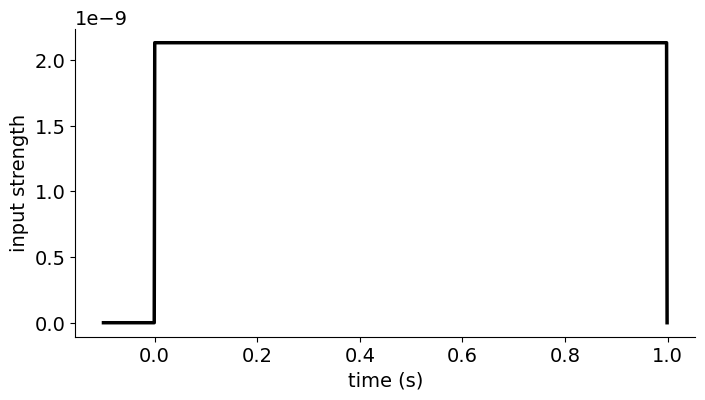

In [14]:
# plot timing input
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

prestim = 0.1 # seconds
trange = np.arange(-prestim, 1., 0.001)

timing_input = np.concatenate([np.repeat(0, prestim*1000), 
                              spa.similarity(divided_attention_dt['timing_input'].values[0],
                                             vocab)[:1000,4]])
ax.plot(trange, timing_input, 
         color='black', lw=2.5)

ax.set_xlabel('time (s)')
ax.set_ylabel('input strength')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.savefig('time_input.png', bbox_inches='tight')

In [15]:
cmap = categorical_cmap(5, 1)
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', cmap.colors)

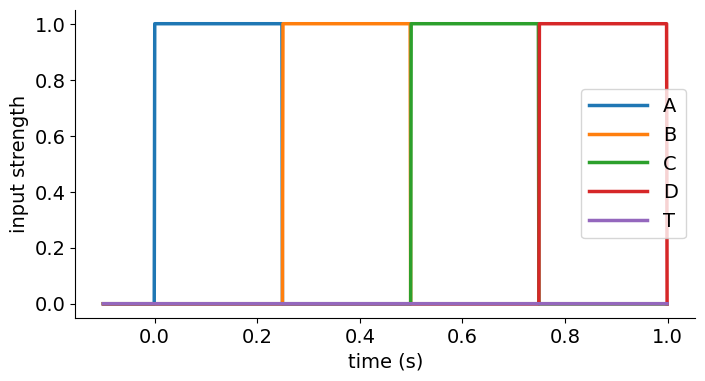

In [16]:
# plot stimulus input
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

prestim = 0.1 # seconds
trange = np.arange(-prestim, 1., 0.001)

stimulus_input = np.concatenate([np.zeros([int(prestim*1000), 5]), 
                              spa.similarity(divided_attention_dt['stimulus_input'].values[0],
                                             vocab)[:1000,0:5]])

sp_list = ['A', 'B', 'C', 'D', 'T']
for i in range(0, 5):
    ax.plot(trange, stimulus_input[:, i], lw=2.5, label=sp_list[i])
    
ax.legend()
    
ax.set_xlabel('time (s)')
ax.set_ylabel('input strength')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.savefig('stimulus_input.png', bbox_inches='tight')

In [17]:
# reconstruct temporal window for t-vector
prospective_estimates = []
t_temporal_window = []
for i in range(len(gi_list)):
    temp, y = readout_window(np.moveaxis(pro_state[i], 1, 0), D, 999, dim, vocab['T'].v)
    prospective_estimates.append(np.mean(temp))
    t_temporal_window.append(temp)

/Users/Joost/opt/anaconda3/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1746: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


In [18]:
# reconstruct temporal window for a-vector
a_temporal_window = []
for i in range(len(gi_list)):
    temp, y = readout_window(np.moveaxis(pro_state[i], 1, 0), D, 999, dim, vocab['A'].v)
    a_temporal_window.append(temp)

In [19]:
grey_cmap = plt.cm.Greys(np.linspace(0.4, 1, 5))
grey_cycler = cycler.cycler('color', grey_cmap)

rainbow_cmap = categorical_cmap(4, 5)
rainbow_cycler = cycler.cycler('color', rainbow_cmap.colors)

blue_cmap = categorical_cmap(1, 5)
blue_cycler = cycler.cycler('color', blue_cmap.colors[::-1])


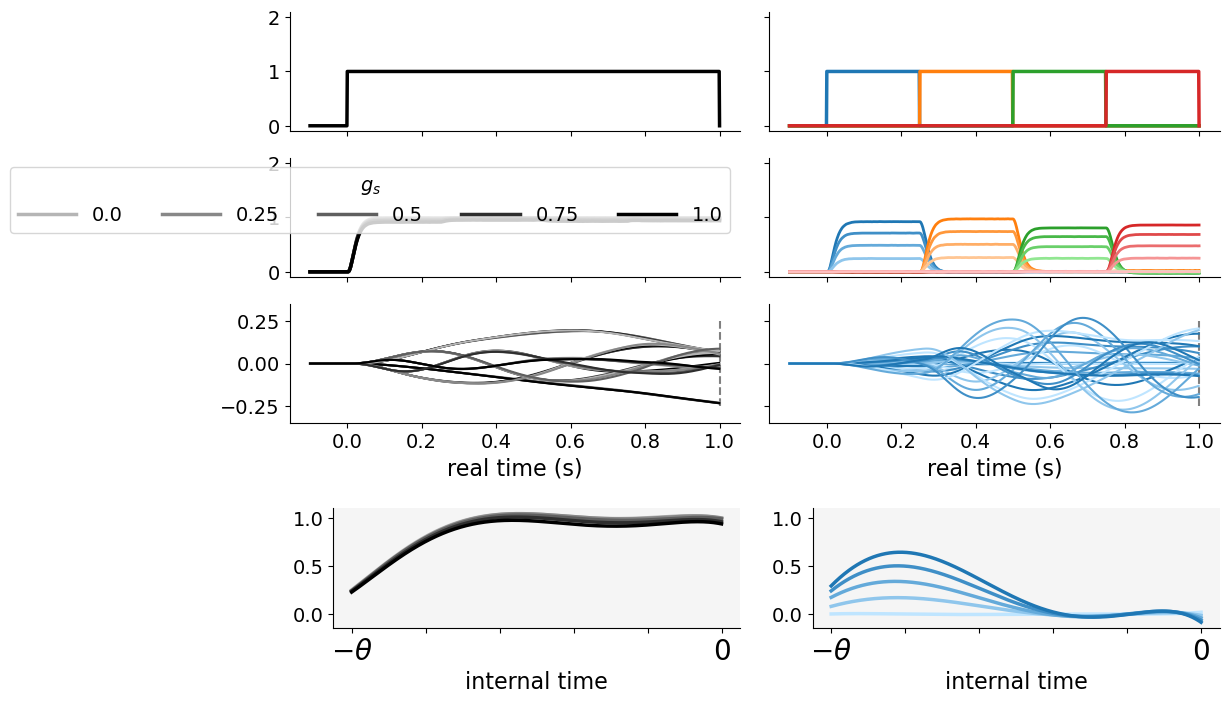

In [20]:
fig = plt.figure(figsize=(12, 8))
grid = plt.GridSpec(22, 22, wspace=2., hspace=10.)

plt.rcParams['font.size'] = '14'

#-----------
# t input
t_input = fig.add_subplot(grid[0:5, 0:11])
trange = np.arange(-prestim, 1., 0.001)

temp = np.concatenate([np.repeat(0, prestim*1000), 
                              spa.similarity(divided_attention_dt['timing_input'].values[0],
                                             vocab)[:1000,-1]])
t_input.plot(trange, temp, 
         color='black', lw=2.5)

t_input.set_ylim([-0.1, 2.1])
t_input.set_yticks(np.linspace(0, 2., num=3))
t_input.set_xticklabels([])
t_input.spines['top'].set_visible(False)
t_input.spines['right'].set_visible(False)

#-----------
# s input
s_input = fig.add_subplot(grid[0:5, 11:22])
trange = np.arange(-prestim, 1., 0.001)

conditions = (divided_attention_dt['task_type']=='prospective_sensory')
temp = np.concatenate([np.zeros([int(prestim*1000), 4]), 
                              spa.similarity(divided_attention_dt['stimulus_input'].values[0],
                                             vocab)[:1000,0:4]])

sp_list = ['A', 'B', 'C', 'D']
for i in range(0, 4):
    s_input.plot(trange, temp[:, i], lw=2.5, label=sp_list[i])

s_input.set_ylim([-0.1, 2.1])
s_input.set_yticks(np.linspace(0, 2., num=3))
s_input.set_yticklabels([])
s_input.set_xticklabels([])
s_input.spines['top'].set_visible(False)
s_input.spines['right'].set_visible(False)

#---------------
# T x_input
tx_input = fig.add_subplot(grid[5:10, 0:11])
trange = np.arange(-prestim, 1., 0.001)

tx_input.set_prop_cycle(grey_cycler)

for i in range(len(gi_list[0:5])):
    temp = np.concatenate([np.squeeze(np.zeros([int(prestim*1000), 1]).T), 
                           nengo.Alpha(0.01).filt(spa.similarity(pro_state_input[i], vocab))[:1000, -1]])
    tx_input.plot(trange, temp, lw=2.5, label=str(gi_list[i]))

tx_input.legend(title=r'$g_s$', ncol=len(gi_list))
    
#ax[0,0].set_ylabel('input strength')
tx_input.set_ylim([-0.1, 2.1])
tx_input.set_yticks(np.linspace(0, 2., num=3))
tx_input.set_xticklabels([])
tx_input.spines['top'].set_visible(False)
tx_input.spines['right'].set_visible(False)

line = [[(0, 0)]]
# set up the proxy artist
lc = mcol.LineCollection(len(gi_list[0:5]) * line, colors=grey_cmap, lw=5)
# create the legend
#leg = tx_input.legend([lc], [r'$g_{s}$'], handler_map={type(lc): HandlerDashedLines()},
#           handlelength=10, handleheight=0.75, fontsize=18, loc='upper left')

#---------------------------------
# S input
sx_input = fig.add_subplot(grid[5:10, 11:22])

prestim = 0.1 # seconds
trange = np.arange(-prestim, 1., 0.001)

sx_input.set_prop_cycle(rainbow_cycler)

for i in range(0, 4):
    for j in reversed(range(0, len(gi_list[0:5]))):
        stimulus_input = np.concatenate([np.repeat(0, prestim*1000),
                              nengo.Alpha(0.01).filt(spa.similarity(pro_state_input[j],
                                             vocab))[:1000,i]])
        sx_input.plot(trange, stimulus_input, lw=2)       
    
sx_input.set_ylim([-0.1, 2.1])
sx_input.set_yticks(np.linspace(0, 2, num=3))
sx_input.set_xticklabels([])
sx_input.set_yticklabels([])
sx_input.spines['top'].set_visible(False)
sx_input.spines['right'].set_visible(False)

# --------
# T Legendre coeff
t_x = fig.add_subplot(grid[10:15, 0:11])
trange = np.arange(-prestim, 1., 0.001)
t_x.set_prop_cycle(grey_cycler)

t_x.vlines(1, -0.25, 0.25, color='grey', ls='--')
for i in range(0, len(gi_list[0:5])):
    t_x.plot(trange, np.concatenate([np.zeros([int(prestim*1000), 6]), 
                              nengo.Alpha(0.05).filt(np.moveaxis(pro_state[i], 1, 0))[:1000, 16, :]]))
    
t_x.set_xlabel('real time (s)', size=16)
t_x.set_ylim([-0.35, 0.35])
#ax[1,0].set_ylabel('Legendre coefficients')
t_x.spines['top'].set_visible(False)
t_x.spines['right'].set_visible(False)

# --------
# T Legendre coeff
t_a = fig.add_subplot(grid[10:15, 11:])
trange = np.arange(-prestim, 1., 0.001)
t_a.set_prop_cycle(blue_cycler)

t_a.vlines(1, -0.25, 0.25, color='grey', ls='--')
for i in range(0, len(gi_list[0:5])):
    t_a.plot(trange, np.concatenate([np.zeros([int(prestim*1000), 6]), 
                              nengo.Alpha(0.05).filt(np.moveaxis(pro_state[i], 1, 0))[:1000, 0, :]]))
    
t_a.set_xlabel('real time (s)', size=16)
t_a.set_ylim([-0.35, 0.35])
#ax[1,0].set_ylabel('Legendre coefficients')
t_a.set_yticklabels([])
t_a.spines['top'].set_visible(False)
t_a.spines['right'].set_visible(False)

# --------
# Temporal Window for T
tw_t = fig.add_subplot(grid[17:22, 1:11])
tw_t.set_prop_cycle(grey_cycler)


trange = np.linspace(-1, 0, 1000)
for i in range(len(gi_list[0:5])):
    tw_t.plot(trange, t_temporal_window[i],
             lw=2.5, label=gi_list[i])
        
#tw_t.legend(title='g_i')   

tw_t.set_xlabel('internal time', size=16)
tw_t.set_facecolor('whitesmoke')
tw_t.set_xticks(np.linspace(-1, 0, num=6))
tw_t.set_xticklabels([r'$-\theta$', '', '', '', '', 0], 
                    size=20)
tw_t.set_yticks(np.linspace(0, 1, num=3))
#tw_t.spines['top'].set_linewidth(1.5)
#tw_t.spines['right'].set_linewidth(1.5)
#tw_t.spines['bottom'].set_linewidth(1.5)
#tw_t.spines['left'].set_linewidth(1.5)

# --------
# Temporal Window for A
tw_a = fig.add_subplot(grid[17:22, 12:], sharey=tw_t)
tw_a.set_prop_cycle(blue_cycler)


trange = np.linspace(-1, 0, 1000)
for i in range(len(gi_list[0:5])):
    tw_a.plot(trange, a_temporal_window[i],
             lw=2.5, label=gi_list[i])
        
#tw_t.legend(title='g_i')   

tw_a.set_xlabel('internal time', size=16)
tw_a.set_xticks(np.linspace(-1, 0, num=6))
tw_a.set_xticklabels([r'$-\theta$', '', '', '', '', 0], 
                    size=20)
tw_a.set_facecolor('whitesmoke')
#tw_a.spines['top'].set_linewidth(1.5)
#tw_a.spines['right'].set_linewidth(1.5)
#tw_a.spines['bottom'].set_linewidth(1.5)
#tw_a.spines['left'].set_linewidth(1.5)

# adjust tickparams
#t_input.tick_params(axis='both', which='major', labelsize=14)
#s_input.tick_params(axis='both', which='major', labelsize=14)
#t_x.tick_params(axis='both', which='major', labelsize=14)
#t_a.tick_params(axis='both', which='major', labelsize=14)
#tw_t.tick_params(axis='x', which='major', labelsize=18)
#tw_a.tick_params(axis='x', which='major', labelsize=18)
#tw_t.tick_params(axis='y', which='major', labelsize=14)
#tw_a.tick_params(axis='y', which='major', labelsize=14)


#plt.savefig('pro_retro_traces.png', bbox_inches='tight', dpi=300)
#plt.savefig('pro_retro_traces.svg', bbox_inches='tight', transparent=False, pad_inches=0)

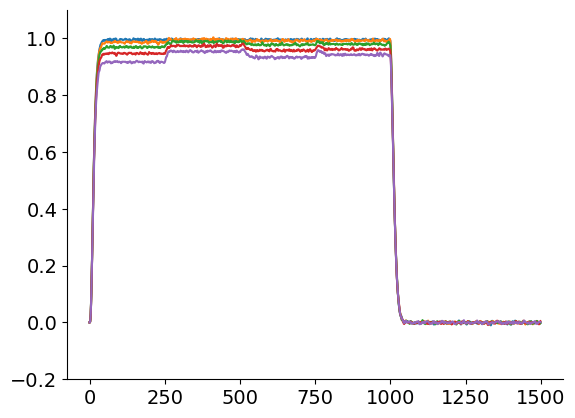

In [21]:
for i in range(5):
    plt.plot(spa.similarity(nengo.Alpha(0.005).filt(pro_state_input[i]), vocab)[:, -1])
    plt.ylim([-0.2, 1.1])

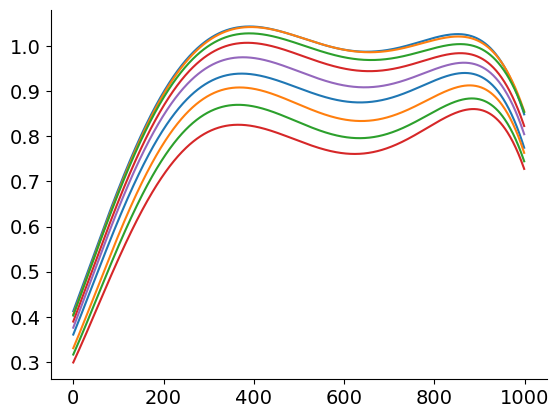

In [22]:
prospective_estimates = []
stim_decoding = []
contextual_change = []

sp_list = ['A', 'B', 'C', 'D']

trange = np.linspace(-1, 0, 1000)
for i in range(len(gi_list)):
    # prospective estimate
    temp, y = readout_window(np.moveaxis(pro_state[i], 1, 0), D, 1050, dim, vocab['T'].v)
    plt.plot(temp)
    prospective_estimates.append(np.mean(abs(temp)))
    
    temp_dec = [] # maximal stimulus decoding estimate
    temp_ch = [] # retrospective estimate
    for sp in sp_list:
        temp, y = readout_window(np.moveaxis(pro_state[i], 1, 0), D, 1050, dim, vocab[sp].v)
        
        temp_ch.append(np.mean(abs(temp)))
        
        if sp == 'A':
            stim_temp, y = readout_window(np.moveaxis(pro_state[i], 1, 0), D, 1000, dim, vocab[sp].v)
            temp_dec = np.max(stim_temp)
        
    stim_decoding.append(temp_dec)
    contextual_change.append(np.sum(np.asarray(temp_ch)))
    

prospective_estimates = np.asarray(prospective_estimates)  
stim_decoding = np.asarray(stim_decoding)  
contextual_change = np.asarray(contextual_change)



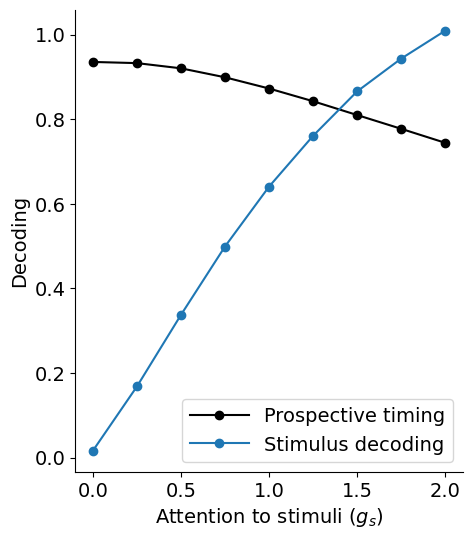

In [23]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 6))

# Prospective timing
ax1.plot(gi_list, prospective_estimates, color='black', 
         marker='o', label='Prospective timing')
#ax1.scatter(gi_list, prospective_estimates, color='black', label='Prospective timing')
ax1.set_xlabel('Attention to stimuli $(g_s)$')
ax1.set_ylabel('Decoding')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Stimulus decoding
ax1.plot(gi_list, stim_decoding, 
         marker='o', label='Stimulus decoding')
#ax1.scatter(gi_list, stim_decoding, label='Stimulus decoding')
ax1.set_xlabel('Attention to stimuli $(g_s)$')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.legend()

fig.savefig('bi_directional_plot.png', dpi=400)
fig.savefig('bi_directional_plot.tiff', dpi=400, bbox_inches='tight')

In [24]:
pro_state[i].shape

(64, 1500, 6)